In [ ]:
import os
import copy
import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
import uproot3
import mplhep as hep

In [ ]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise
        
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [ ]:
def printColorText(text, color): # both the input text and the color desired are input as strings
    whichcolor = {
                    'red':'\033[91m' + text,
                    'yellow':'\033[93m' + text,
                    'green':'\033[92m' + text,
                    'blue':'\033[96m' + text,
                    'indigo':'\033[94m' + text,
                    'violet':'\033[95m' + text,
                }
    print(whichcolor.get(color) + '\033[90m')
    # The added string on the end resets the default colored text to black #

# ---- Test the function ---- #
print('this sentence is black by default')
printColorText('this sentence should be violet', 'violet')
print('this sentence is defaulted to black after printColorText')

In [ ]:
def ConvertLabelToInt(mapping, str_label):
    for intkey, string in mapping.items():
        if str_label == string:
            return intkey

In [ ]:
def plotratio(numerator, denominator, ax=None, histtype='errorbar', marker='.', markersize=5., color='k', alpha=0.1):
    NumeratorAxes = numerator.axes
    DenominatorAxes = denominator.axes
    
    # integer number of bins in this axis #
    NumeratorAxis1_BinNumber = NumeratorAxes[0].size - 3 # Subtract 3 to remove overflow
    
    DenominatorAxis1_BinNumber = DenominatorAxes[0].size - 3 
    
    if(NumeratorAxis1_BinNumber != DenominatorAxis1_BinNumber):
        raise Exception('Numerator and Denominator axes are different sizes; Cannot perform division.')
    # else:
    #     Numerator = numerator.to_hist()
    #     Denominator = denominator.to_hist()
        
    ratio = numerator / denominator.values()
    
    if histtype == 'errorbar':
        return hep.histplot(ratio, ax=ax, histtype=histtype, marker=marker, markersize=markersize, color=color)
    elif histtype == 'fill':
        return hep.histplot(ratio, ax=ax, histtype=histtype, color=color, alpha=alpha, lw=5.)
    else:
        return hep.histplot(ratio, ax=ax, histtype=histtype, color=color)

In [ ]:
dir1 = 'CoffeaOutputsForCombine/Coffea_FirstRun/'
dir2 = 'CoffeaOutputsForCombine/Coffea_SecondRun/'
btagDir = 'MediumBTag/'#'LooseBTag/'
yearDir = '2016/'
APVDir = 'noAPV/'
od = ''

if btagDir == '':
    od = '_oldANdisc'

# Systematic Correction / Uncertainty + Reweighting Label
## Set the strings accordingly
#### For bTagSyst: '_btagUnc_\<syst\>' where \<syst\> can be either $central$, $up$ or $down$
#### For Top $p_T$ Reweight: '_TopReweight'

In [ ]:
Unc = '_btagUnc_central_method2' #_btagUnc_central_method2
TopPt = '' #_TopReweight
UncDir = Unc
TopPtDir = TopPt
if Unc != '':
    UncDir = Unc + '/'
if TopPt != '':
    TopPtDir = 'TopReweight/'

In [ ]:
JetHT2016_str = 'TTbarRes_0l_UL16postVFP_JetHT_Data'
TTbar_str = 'TTbarRes_0l_UL16postVFP_TTbar'

In [ ]:
JetHT2016_wgt_str = JetHT2016_str + '_weighted' + Unc
TTbar_wgt_str = TTbar_str + '_weighted' + Unc + TopPt

## Import First Uproot Job Coffea Outputs (Unweighted by Mistag Rates)

In [ ]:
JetHT2016_unweighted = util.load(dir1 + 'JetHT/' + btagDir + yearDir + APVDir + JetHT2016_str + od + '.coffea')
TTbar_unweighted = util.load(dir1 + 'TT/' + btagDir + yearDir + APVDir + TTbar_str + od + '.coffea')

## Import Second Uproot Job Coffea Outputs (Weighted by Mistag Rates)

In [ ]:
JetHT2016_weighted = util.load(dir2 + 'JetHT/' + btagDir + yearDir + APVDir + JetHT2016_wgt_str + od + '.coffea')
TTbar_weighted = util.load(dir2 + 'TT/' + btagDir + yearDir + APVDir + TTbar_wgt_str + od + '.coffea')

## Cutflow

In [ ]:
outputs_unweighted =     {'JetHT 2016': JetHT2016_unweighted,
                          'TTbar': TTbar_unweighted
                         }

outputs_weighted  =      {'JetHT 2016': JetHT2016_weighted,
                          'TTbar': TTbar_weighted
                         }

In [ ]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

In [ ]:
for name,output in outputs_weighted.items(): 
    print("-------Weighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

In [ ]:
for name,output in outputs_unweighted.items(): 
    print("-------Ratios " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12f' % (i,j/output['cutflow']['all events']) )

## Scale Factor to Normalize $t\bar{t}$
### Either $\frac{\sigma L}{\sum w_i}$ or $\frac{\Gamma(t\bar{t}\rightarrow q\bar{q}q\bar{q})}{\Gamma(t\bar{t})}\times\frac{\kappa L}{N_{\mathit{evts}}}$

## Scale Factor to Scale up the Data

In [ ]:
Nevts2016 = 625441538 # from dasgoclient
Nevts2016_sf = Nevts2016/JetHT2016_unweighted['cutflow']['all events']
Nevts2016_sf_wgt = Nevts2016/JetHT2016_weighted['cutflow']['all events']

print(Nevts2016_sf)
print(Nevts2016_sf_wgt)

In [ ]:
Lum2016 = 35920./Nevts2016_sf_wgt # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable #Divided by 3 due to blinding

t_BR = 0.67
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs = 831.76  #pb  Set this to 1 if not dividing by sumw, and we get a reasonable normalization for ttbar
toptag_kf = 0.70 # k-factor from https://github.com/cmsb2g/B2GTTbar/blob/master/test/MakeMistag_SubtractAndDivideAntiTag_B2G2016.cc#L472

ttbar2016_sf = ttbar_xs*Lum2016/TTbar_unweighted['cutflow']['sumw']
ttbar2016_sf_wgt = ttbar_xs*Lum2016/TTbar_weighted['cutflow']['sumw']

ttbar2016_sf2 = Lum2016*ttbar_BR*toptag_kf/TTbar_unweighted['cutflow']['all events']
ttbar2016_sf_wgt2 = Lum2016*ttbar_BR*toptag_kf/TTbar_weighted['cutflow']['all events']

# -- Should be the same given the same number of events in both wgt and unwgt outputs -- #
print('ttbar 2016 scale factor            = ', ttbar2016_sf)
print('ttbar 2016 weighted scale factor   = ', ttbar2016_sf_wgt)

print('ttbar 2016 scale factor 2          = ', ttbar2016_sf2)
print('ttbar 2016 weighted scale factor 2 = ', ttbar2016_sf_wgt2)

## Helpful plotting stuff...

In [ ]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

maindirectory = os.getcwd()

# ---- Reiterate categories ---- #
ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"] 
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
list_of_bcats = [ b+y for b,y in itertools.product( btagcats, ycats) ]
label_cats_dict = {i: label for i, label in enumerate(list_of_cats)}
print(label_cats_dict)
print(ConvertLabelToInt(label_cats_dict, ttagcats[1]+list_of_bcats[2]))

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep')

# ---- Plotting Options ---- #
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
line_background_opts1 = {'color': 'red'}
line_background_opts2 = {'color': 'green'}
line_background_opts3 = {'color': 'blue'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

# Closure Test
## mistag region x mistag rate = testing region
## $|\vec{p}|_{\mathit{all\ probe\ jets}}\ \times\ \frac{|\vec{p}|_{\mathit{t-tagged\ probe\ jets}}}{|\vec{p}|_{\mathit{all\ probe\ jets}}}\ =\ |\vec{p}|_{\mathit{t-tagged\ probe\ jets}}$
## JetHT data in mistag region 'at' (Anti-tag and probe region) that is weighted with mistag rate should give back JetHT unweighted data in 'Probet' region (Anti-tag and t-tagged probe region)
## NOTE: This test is not precise unless both weighted and unweighted JetHT samples have the same number of events in cutflow (check 'all events' for both)

In [ ]:
""" ---------- Comparing Background Estimate to unweighted Data ---------- """

SaveDirectory = maindirectory + '/ClosureTests/' + btagDir + yearDir + APVDir
DoesDirectoryExist(SaveDirectory)

for b_y in list_of_bcats:
    #---- Histogram Window Config. ----# 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)
    #b_y = '0bcen' # b-tag category and rapidity window

    legend_labels = {'labels':['', 'All Probe Jets Weighted with MTR', 'T-Tagged Probe Jets'],
                             'loc': 'upper right',
                             'fontsize': 'x-small'}

    #---- Useful Information (Debug Purposes Only)----# 
    lut_file = maindirectory + '/LookupTables/MediumBTag/mistag_UL16postVFP_JetHT_Data_ttContaminationRemoved_at' + b_y + '.csv'
    df = pd.read_csv(lut_file)
    p_vals = df['p'] # Momentum (GeV)
    mtr = df['M(p)'].values # Mistag Rate
    MMR = mtr.sum()/mtr.size
    print('Mean Mistag Rate (MMR) = ', MMR)

    #---- Check if these two cutflows are the same ----#
    all_evts_unwgt = JetHT2016_unweighted['cutflow']['all events']
    all_evts_wgt = JetHT2016_weighted['cutflow']['all events']
    nevts = JetHT2016_unweighted['cutflow']['at'+b_y] # Anti-tag jet
    bkg_nevts = JetHT2016_weighted['cutflow']['at'+b_y] # (Anti-tag jets) x mtr
    exp_nevts = JetHT2016_unweighted['cutflow']['AT&Pt'+b_y] # Anti-tag and t-tagged Probe pairs
    
    print('All JetHT2016 unweighted events = ', all_evts_unwgt)
    print('All JetHT2016 weighted events = ', all_evts_wgt)
    if all_evts_unwgt != all_evts_wgt:
        printColorText('\n*NOTE* This test is not accurate', 'red')
    print()
    print('Number of Weighted "at" Data; Estimate (Cutflow) =   ', bkg_nevts)
    print('Number of Unweighted "AT&Pt" Data (Cutflow) = ', exp_nevts)
    print()

    #---- Define Histogram categories of interest which should be equal ----# 
    hist_wgt_anacat = 'at' + b_y # category of interest for the weighted data (all weighted probe jets)
    hist_unwgt_at_anacat = hist_wgt_anacat
    hist_unwgt_anacat = 'AT&Pt' + b_y # category of interest for the un-weighted data (unweighted t-tagged probe jets)
    
    #---- Given pairs of jets where one jet is anti-tagged, show the momentum of the probe jets ----#
    hist_unwgt_at = JetHT2016_unweighted['probep'][JetHT2016_str[12:], ConvertLabelToInt(label_cats_dict, hist_unwgt_at_anacat), :]
    hist_wgt = JetHT2016_weighted['probep'][JetHT2016_str[12:], ConvertLabelToInt(label_cats_dict, hist_wgt_anacat), :]
    hist_unwgt = JetHT2016_unweighted['probep'][JetHT2016_str[12:], ConvertLabelToInt(label_cats_dict, hist_unwgt_anacat), :]
    
    # ---- Data Scaling ---- #
    hist_wgt *= Nevts2016_sf_wgt
    hist_unwgt *= Nevts2016_sf
    hist_unwgt_at *= Nevts2016_sf
    
    # all probe jets weighted with mistag rate (including tt contam. subtraction) #
    hist_wgt.plot1d(ax=ax, histtype='fill', color='yellow')
    hist_unwgt.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k') # all unweighted, t-tagged probe jets

    d = {'p': p_vals, 'M(p)': mtr, 'unwgt at'+b_y: hist_unwgt_at.view().value, 
         'wgt at'+b_y: hist_wgt.view().value, 
         'unwgt AT&Pt'+b_y: hist_unwgt.view().value}
    df1 = pd.DataFrame(data=d)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(df1)

    ax.set_yscale('linear')
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title('Probe Momentum Closure Test ' + b_y)
    leg = ax.legend(labels=[r'All Probe Jets Weighted with MTR', r'Unweighted T-Tagged Probe Jets'], bbox_to_anchor=(1.4, 1.), loc='upper right')

    #---- Plot Ratio ----#
    plotratio(hist_unwgt, hist_wgt, ax = rax, histtype='errorbar', marker='.', markersize=5., color='k')
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    rax.set_xlim(0,3000)

    #---- Labeling ----#
    lumi = plt.text(1.18, 1.07, "2016 Data", #"?? fb$^{-1}$",
            fontsize=16,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )
    
    filename = 'ClosureTest_Simple_' + name + Unc + TopPt + '_' + b_y + '.png'
    # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    print('\n' + SaveDirectory + filename)

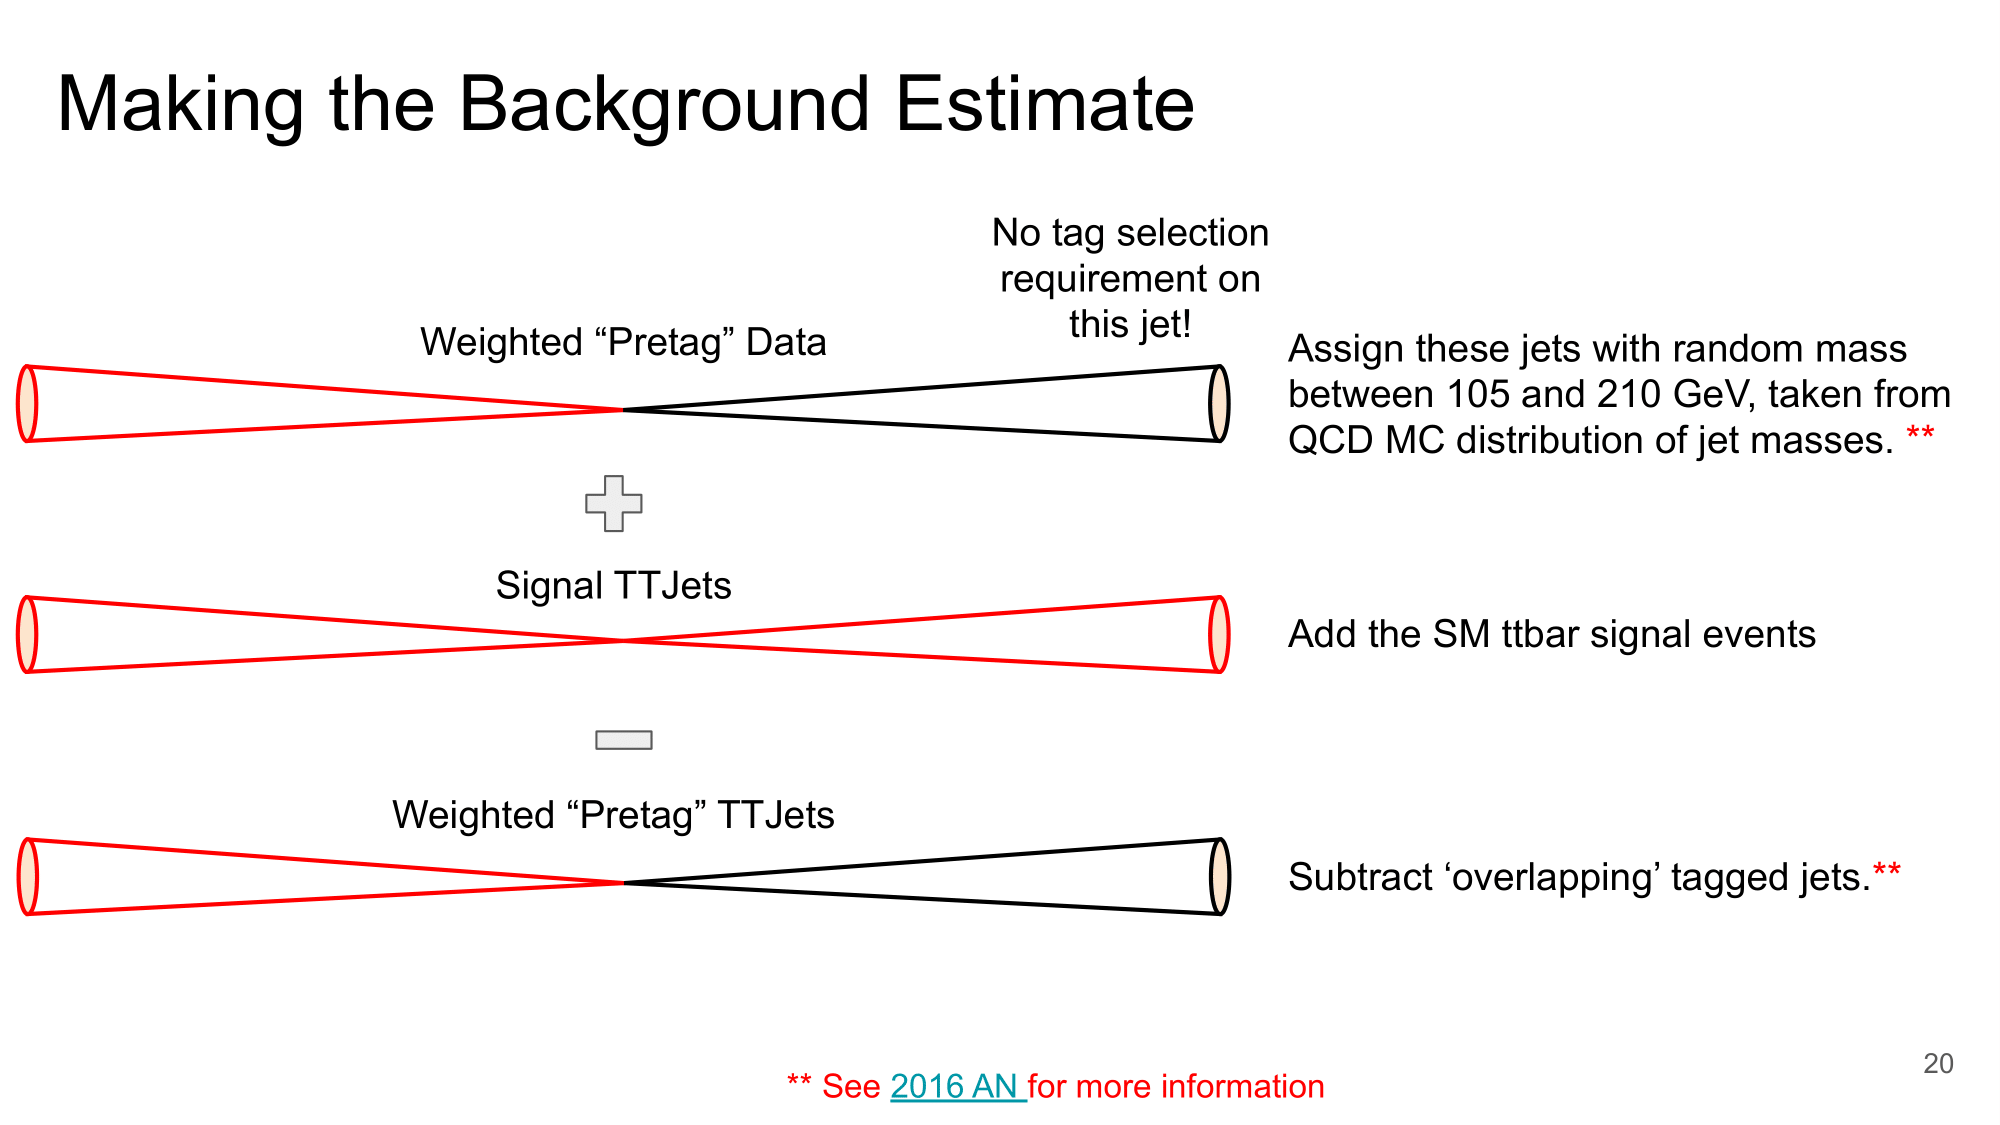

# Making the Background Estimate
## Step 1.)
### Plot NTMJ Bkg. Est. from Pre-tagged Region of Data Weighted by Mistag Rate

In [ ]:
# #---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

# name = list_of_hists[0]

# for b_y in list_of_bcats:
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
#     fig, (ax, rax) = plt.subplots(
#         nrows=2,
#         ncols=1,
#         figsize=(7,7),
#         gridspec_kw={"height_ratios": (3, 1)},
#         sharex=True
#     )
#     fig.subplots_adjust(hspace=.07)

#     #---- Print cutflow of events (Debug Purposes Only)----#
#     # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
#     # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
#     # =============================================================================================================================== #

#     # ---- Define Histograms from Coffea Outputs ---- # 
    
#     # -- For Observed Signal (Data) -- #
#     Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

#     # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
#     NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])

#     # =============================================================================================================================== #

#     # ---- Data Scaling ---- #
#     Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
#     NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up

#     # =============================================================================================================================== #

#     # ---- Background and Observed Signal for Histograms ---- #

#     # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate-- #
#     Background = NTMJ_hist 

#     # -- Simple Observed Data in Signal Region -- #
#     Observed = Data_hist 

#     # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
#     legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'Data'], 
#                      'ncol':1, 
#                      'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
#                      'fontsize': 'xx-small'}



#     # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
#     ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
#                  error_opts=data_err_opts)
#     BackgroundPlot = hist.plot1d(Background, ax=ax, clear=False,
#                 fill_opts=stack_background_opts,
#                 error_opts=stack_error_opts, legend_opts=legend_labels)


#     plt.ylim(bottom = .1, top = 10**4)

#     ax.set_yscale('log')
#     ax.autoscale('y')
#     ax.autoscale('x')#, tight=True) # doesn't look like its working...
#     ax.set_ylabel('Events')
#     ax.set_xlabel(None)
#     ax.set_title(name + ' ' + b_y)

#     #---- Plot Ratio ----#
#     RatioPlot = hist.plotratio(num = Observed, denom = Background, ax = rax,
#                    error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
#                    unc = 'num')
#     rax.set_ylabel('Data/Bkg')
#     rax.axhline(y=1, color='k', linestyle=':')
#     rax.set_ylim(0,2)
#     if 'ttbarmass' in name:
#         rax.set_xlim(800,5000)
#     elif 'jetpt' in name:
#         rax.set_xlim(400,1500)
#     elif 'jeteta' in name:
#         rax.set_xlim(-2.3,2.3)
#     elif 'jetphi' in name:
#         rax.set_xlim(-3.14, 3.14)
#     elif 'jety' in name:
#         rax.set_xlim(-3., 3.)
#     elif 'jetdy' in name:
#         rax.set_xlim(0., 5.)
#     elif 'probept' in name:
#         rax.set_xlim(400., 2000.)   
#     elif 'probep' in name:
#         rax.set_xlim(400., 7000.)  

#     #rax.set_xlim(0,500)

#     #---- Labeling ----#
#     Lint = str(Lum2016*.001) # Integrated Luminosity
#     lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
#             fontsize=16,
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax.transAxes
#            )

# Making the Background Estimate
## Step 2.)
### Add the SM $t\bar{t}$ to the NTMJ Bkg. Est. to account for the SM contribution to the background in the signal region

In [ ]:
# #---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

# name = list_of_hists[0]

# for b_y in list_of_bcats:
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
#     fig, (ax, rax) = plt.subplots(
#         nrows=2,
#         ncols=1,
#         figsize=(7,7),
#         gridspec_kw={"height_ratios": (3, 1)},
#         sharex=True
#     )
#     fig.subplots_adjust(hspace=.07)

#     #---- Print cutflow of events (Debug Purposes Only)----#
#     # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
#     # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
#     # =============================================================================================================================== #

#     # ---- Define Histograms from Coffea Outputs ---- # 
    
#     # -- For Observed Signal (Data) -- #
#     Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

#     # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
#     NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])
    
#     # -- SM ttbar to add to bkg est -- #
#     SMTTbar_hist = TTbar_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', TTbar_str[12:])

#     # =============================================================================================================================== #

#     # ---- Data Scaling ---- #
#     Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
#     NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up
    
#     # ---- MC Normalization ---- #
#     SMTTbar_hist.scale(ttbar2016_sf)
    
#     # =============================================================================================================================== #

#     # ---- Background and Observed Signal for Histograms ---- #

#     # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate -- #
#     Background = NTMJ_hist 
    
#     # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added -- #
#     Background.add(SMTTbar_hist)

#     # -- Simple Observed Data in Signal Region -- #
#     Observed = Data_hist 

#     # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
#     legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'Data'], 
#                      'ncol':1, 
#                      'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
#                      'fontsize': 'xx-small'}



#     # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
#     ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
#                  error_opts=data_err_opts)
#     BackgroundPlot = hist.plot1d(Background, ax=ax, clear=False,
#                 fill_opts=stack_background_opts,
#                 error_opts=stack_error_opts, legend_opts=legend_labels)


#     plt.ylim(bottom = .1, top = 10**4)

#     ax.set_yscale('log')
#     ax.autoscale('y')
#     ax.autoscale('x')#, tight=True) # doesn't look like its working...
#     ax.set_ylabel('Events')
#     ax.set_xlabel(None)
#     ax.set_title(name + ' ' + b_y)

#     #---- Plot Ratio ----#
#     RatioPlot = hist.plotratio(num = Observed, denom = Background, ax = rax,
#                    error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
#                    unc = 'num')
#     rax.set_ylabel('Data/Bkg')
#     rax.axhline(y=1, color='k', linestyle=':')
#     rax.set_ylim(0,2)
#     if 'ttbarmass' in name:
#         rax.set_xlim(800,5000)
#     elif 'jetpt' in name:
#         rax.set_xlim(400,1500)
#     elif 'jeteta' in name:
#         rax.set_xlim(-2.3,2.3)
#     elif 'jetphi' in name:
#         rax.set_xlim(-3.14, 3.14)
#     elif 'jety' in name:
#         rax.set_xlim(-3., 3.)
#     elif 'jetdy' in name:
#         rax.set_xlim(0., 5.)
#     elif 'probept' in name:
#         rax.set_xlim(400., 2000.)   
#     elif 'probep' in name:
#         rax.set_xlim(400., 7000.)  

#     #rax.set_xlim(0,500)

#     #---- Labeling ----#
#     Lint = str(Lum2016*.001) # Integrated Luminosity
#     lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
#             fontsize=16,
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax.transAxes
#            )

# Making the Background Estimate
## Step 3.)
### Subtract overlapping top events from the pre-tag region

In [ ]:
# #---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

# name = list_of_hists[0]

# for b_y in list_of_bcats:
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
#     fig, (ax, rax) = plt.subplots(
#         nrows=2,
#         ncols=1,
#         figsize=(7,7),
#         gridspec_kw={"height_ratios": (3, 1)},
#         sharex=True
#     )
#     fig.subplots_adjust(hspace=.07)

#     #---- Print cutflow of events (Debug Purposes Only)----#
#     # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
#     # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
#     # =============================================================================================================================== #

#     # ---- Define Histograms from Coffea Outputs ---- # 
    
#     # -- For Observed Signal (Data) -- #
#     Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

#     # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
#     NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])
    
#     # -- SM ttbar to add to bkg est -- #
#     SMTTbar_hist = TTbar_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', TTbar_str[12:])
    
#     # -- SM ttbar to add to bkg est -- #
#     ExtraTTbar_hist = TTbar_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', TTbar_str[12:])

#     # =============================================================================================================================== #

#     # ---- Data Scaling ---- #
#     Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
#     NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up
    
#     # ---- MC Normalization ---- #
#     SMTTbar_hist.scale(ttbar2016_sf)
#     ExtraTTbar_hist.scale(-ttbar2016_sf_wgt) # note the negative sign, because COFFEA only adds hists, even though we must subtract
    
#     # =============================================================================================================================== #

#     # ---- Background and Observed Signal for Histograms ---- #

#     # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate -- #
#     Background = NTMJ_hist 
    
#     # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added -- #
#     Background.add(SMTTbar_hist)
    
#     # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added, Double Counting ttbar Subtracted -- #
#     Background.add(ExtraTTbar_hist)

#     # -- Simple Observed Data in Signal Region -- #
#     Observed = Data_hist 

#     # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
#     legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'Data'], 
#                      'ncol':1, 
#                      'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
#                      'fontsize': 'xx-small'}



#     # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
#     ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
#                  error_opts=data_err_opts)
#     BackgroundPlot = hist.plot1d(Background, ax=ax, clear=False,
#                 fill_opts=stack_background_opts,
#                 error_opts=stack_error_opts, legend_opts=legend_labels)


#     plt.ylim(bottom = .1, top = 10**4)

#     ax.set_yscale('log')
#     ax.autoscale('y')
#     ax.autoscale('x')#, tight=True) # doesn't look like its working...
#     ax.set_ylabel('Events')
#     ax.set_xlabel(None)
#     ax.set_title(name + ' ' + b_y)

#     #---- Plot Ratio ----#
#     RatioPlot = hist.plotratio(num = Observed, denom = Background, ax = rax,
#                    error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
#                    unc = 'num')
#     rax.set_ylabel('Data/Bkg')
#     rax.axhline(y=1, color='k', linestyle=':')
#     rax.set_ylim(0,2)
#     if 'ttbarmass' in name:
#         rax.set_xlim(800,5000)
#     elif 'jetpt' in name:
#         rax.set_xlim(400,1500)
#     elif 'jeteta' in name:
#         rax.set_xlim(-2.3,2.3)
#     elif 'jetphi' in name:
#         rax.set_xlim(-3.14, 3.14)
#     elif 'jety' in name:
#         rax.set_xlim(-3., 3.)
#     elif 'jetdy' in name:
#         rax.set_xlim(0., 5.)
#     elif 'probept' in name:
#         rax.set_xlim(400., 2000.)   
#     elif 'probep' in name:
#         rax.set_xlim(400., 7000.)  

#     #rax.set_xlim(0,500)

#     #---- Labeling ----#
#     Lint = str(Lum2016*.001) # Integrated Luminosity
#     lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
#             fontsize=16,
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax.transAxes
#            )

# Visualize All Three Steps Together

In [ ]:
#---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

SaveDirectory = maindirectory + '/BkgEstStepsImages/' + btagDir + yearDir + APVDir
DoesDirectoryExist(SaveDirectory)

name = list_of_hists[7]

for b_y in list_of_bcats:
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, ([ax, bx], [rax, rbx]) = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(20,9),
        gridspec_kw={"height_ratios": (4, 1)},
        sharex=True,
        sharey='row'
    )
    fig.subplots_adjust(hspace=.05)
    fig.subplots_adjust(wspace=.05)

    #---- Print cutflow of events (Debug Purposes Only)----#
    # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
    # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
    # =============================================================================================================================== #

    # ---- Define Histograms from Coffea Outputs ---- # 
    
    # -- For Observed Signal (Data) -- #
    Data_hist = JetHT2016_unweighted[name][JetHT2016_str[12:], ConvertLabelToInt(label_cats_dict, '2t'+b_y), :]

    # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
    NTMJ_hist = JetHT2016_weighted[name][JetHT2016_str[12:], ConvertLabelToInt(label_cats_dict, 'pret'+b_y), :]
    
    # -- SM ttbar to add to bkg est -- #
    SMTTbar_hist = TTbar_unweighted[name][TTbar_str[12:], ConvertLabelToInt(label_cats_dict, '2t'+b_y), :]
    SMTTbar_hist2 = SMTTbar_hist.copy()
    
    # -- SM ttbar to subtract from bkg est -- #
    ExtraTTbar_hist = TTbar_weighted[name][TTbar_str[12:], ConvertLabelToInt(label_cats_dict, 'pret'+b_y), :]
    ExtraTTbar_hist2 = ExtraTTbar_hist.copy()
    
    # =============================================================================================================================== #

    # ---- Data Scaling ---- #
    Data_hist *= Nevts2016_sf # Observed Signal is scaled up
    NTMJ_hist *= Nevts2016_sf_wgt # NTMJ Bkg. Est. is scaled up
    
    # ---- MC Normalization ---- #
    SMTTbar_hist *= ttbar2016_sf
    ExtraTTbar_hist *= (-ttbar2016_sf_wgt) # note the negative sign, because COFFEA only adds hists, even though we must subtract
    
    SMTTbar_hist2 *= ttbar2016_sf2
    ExtraTTbar_hist2 *= (-ttbar2016_sf_wgt2) # note the negative sign, because COFFEA only adds hists, even though we must subtract

    # =============================================================================================================================== #

    # ---- Background and Observed Signal for Histograms ---- #

    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate -- #
    Background = NTMJ_hist 
    Background_step1 = Background.copy()
    Background_step2 = Background.copy()
    Background_step3 = Background.copy()
    Background_step1_2 = Background.copy()
    Background_step2_2 = Background.copy()
    Background_step3_2 = Background.copy()
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, Double Counting ttbar Subtracted -- #
    Background_step2 += (ExtraTTbar_hist)
    Background_step2_2 += (ExtraTTbar_hist2)
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, Double Counting ttbar Subtracted, SM ttbar added -- #
    Background_step3 += (ExtraTTbar_hist)
    Background_step3 += (SMTTbar_hist)
    Background_step3_2 += (ExtraTTbar_hist2)
    Background_step3_2 += (SMTTbar_hist2)
    
    # -- Simple Observed Data in Signal Region -- #
    Observed = Data_hist 

    # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
    ll = [r'NTMJ Bkg. Est.', r'NTMJ Bkg. Est. $-\ t\bar{t}_{\mathit{Contamination}}$', 
                               r'NTMJ Bkg. Est. $-\ t\bar{t}_{\mathit{Contamination}}\ +$ SM $t\bar{t}$', r'Data']
    # legend_labels = {'labels':ll, 
    #                  'ncol':1, 
    #                  'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
    #                  'fontsize': 'large'}

    # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
    ObservedPlot = Observed.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k')
    BackgroundPlot1 = Background_step1.plot1d(ax=ax, histtype='step', color='red')
    BackgroundPlot2 = Background_step2.plot1d(ax=ax, histtype='step', color='green')
    BackgroundPlot3 = Background_step3.plot1d(ax=ax, histtype='step', color='blue')
    
    ObservedPlot2 = Observed.plot1d(ax=bx, histtype='errorbar', marker='.', markersize=5., color='k')
    BackgroundPlot1_2 = Background_step1_2.plot1d(ax=bx, histtype='step', color='red')
    BackgroundPlot2_2 = Background_step2_2.plot1d(ax=bx, histtype='step', color='green')
    BackgroundPlot3_2 = Background_step3_2.plot1d(ax=bx, histtype='step', color='blue')

    # plt.ylim(bottom = .1, top = 10**4)
    
    ax.set_yscale('linear')
    ax.yaxis.grid()
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title(r'Norm $\frac{\sigma L}{\sum w_i}$', fontsize='xx-large', loc = 'left', y=1.05)
    # ax.get_legend().remove()
    
    bx.set_yscale('linear')
    bx.yaxis.grid()
    bx.autoscale('y')
    bx.autoscale('x')#, tight=True) # doesn't look like its working...
    bx.set_ylabel('')
    bx.set_xlabel(None)
    bx.set_title(r'Norm $\frac{\Gamma(t\bar{t}\rightarrow q\bar{q}q\bar{q})}{\Gamma(t\bar{t})}\times\frac{\kappa L}{N_{\mathit{evts}}}$', 
                 fontsize='xx-large', loc = 'left', y=1.05)
    
    legtitle = bx.legend(title='category: ' + b_y, title_fontsize='x-large',
              labels=ll, fontsize='medium')
    legtitle._legend_box.align = "left" 
    
    #---- Plot Ratio ----#
    plotratio(Observed, Background_step1, ax = rax, histtype='errorbar', marker='.', markersize=4., color='r')
    plotratio(Observed, Background_step2, ax = rax, histtype='errorbar', marker='.', markersize=4., color='g')
    plotratio(Observed, Background_step3, ax = rax, histtype='errorbar', marker='.', markersize=4., color='b')
    
    plotratio(Observed, Background_step1_2, ax = rbx, histtype='errorbar', marker='.', markersize=4., color='r')
    plotratio(Observed, Background_step2_2, ax = rbx, histtype='errorbar', marker='.', markersize=4., color='g')
    plotratio(Observed, Background_step3_2, ax = rbx, histtype='errorbar', marker='.', markersize=4., color='b')
    
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    if 'ttbarmass' in name:
        rax.set_xlim(800,3000)
    elif 'jetpt' in name:
        rax.set_xlim(400,1500)
    elif 'jeteta' in name:
        rax.set_xlim(-2.3,2.3)
    elif 'jetphi' in name:
        rax.set_xlim(-3.14, 3.14)
    elif 'jety' in name:
        rax.set_xlim(-3., 3.)
    elif 'jetdy' in name:
        rax.set_xlim(0., 5.)
    elif 'probept' in name:
        rax.set_xlim(400., 2000.)   
    elif 'probep' in name:
        rax.set_xlim(400., 7000.)  
        
    rbx.set_ylabel('')
    rbx.axhline(y=1, color='k', linestyle=':')
    rbx.set_ylim(0,2)
    if 'ttbarmass' in name:
        rbx.set_xlim(800,3000)
    elif 'jetpt' in name:
        rbx.set_xlim(400,1500)
    elif 'jeteta' in name:
        rbx.set_xlim(-2.3,2.3)
    elif 'jetphi' in name:
        rbx.set_xlim(-3.14, 3.14)
    elif 'jety' in name:
        rbx.set_xlim(-3., 3.)
    elif 'jetdy' in name:
        rbx.set_xlim(0., 5.)
    elif 'probept' in name:
        rbx.set_xlim(400., 2000.)   
    elif 'probep' in name:
        rbx.set_xlim(400., 2000.)  


    #rax.set_xlim(0,500)

    #---- Labeling ----#
    Lint = str(Lum2016*.001) # Integrated Luminosity
    lumi = plt.text(2.42, 1.00, "L = " + Lint[:6] + " fb$^{-1}$",
            fontsize='xx-large',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )
    coffee = plt.text(1.95, 0.87, u"☕",
                  fontsize=50,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes
                 )
    
    filename = 'BkgEstSteps_' + name + Unc + TopPt + '_' + b_y + '.png'
    # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    print('\n' + SaveDirectory + filename)